In [58]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import os


#Variable Section
table ="TeacherPay1"
contable ="ConTPay"
cwd=os.getcwd()
datafolder='StateOESDatasets'
database = 'TeacherSalary.db'
#ss_xls = os.path.join(cwd,datafolder,datafile) #path of .xls files
ss_db = os.path.join(cwd,database)
conn = sqlite3.connect(ss_db,isolation_level=None)
cur = conn.cursor()

#SQL Statements
TeacherPay_table_sql = """CREATE TABLE IF NOT EXISTS ? (id integer Primary Key, 
                                                                    ST text,
                                                                    STATE text,
                                                                    OCC_CODE text,
                                                                    OCC_TITLE text,
                                                                    TOT_EMP int,
                                                                    A_MEAN int,
                                                                    A_MEDIAN int,
                                                                    year int);.teacher"""

ConsolidatedTeacherPay_table_sql = "CREATE TABLE IF NOT EXISTS ConTPay (id integer Primary Key autoincrement ,ST TEXT, STATE text, OCC_CODE text, OCC_TITLE text, TOT_EMP real, A_MEAN real, A_MEDIAN real, year integer);"

ConsolidatedTeacherPay_insert_sql = """INSERT INTO ConTPay(ST, STATE, OCC_CODE, OCC_TITLE, TOT_EMP, A_MEAN, A_MEDIAN, year) Select ST, STATE, OCC_CODE, OCC_TITLE, TOT_EMP, A_MEAN, A_MEDIAN, year FROM TeacherPay1 WHERE OCC_Code IN ('25-2021','25-2022','25-2023','25-2031','25-2032','25-2041','25-2042','25-2043');"""

drop_table_sql = """ Drop TABLE IF EXISTS %s """ % table

drop_ConTPay_table_sql = """ Drop TABLE IF EXISTS %s """ % contable

rowCount_sql = """SELECT max(rowid) from %s"""% table

#Function Set

# Create Database function
def create_db(db_file):
    try:
        conn = sqlite3.connect(db_file)   #create a database connection to a SQLite database
        print(sqlite3.version)    #Confirmation
        conn.close()
    except Error as e:
        print(e)
    finally:
        conn.close()
    

#create connection function
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

#Row Count for affirmation output
def xlsCounter(db_file):
    wb = load_workbook(db_file, use_iterators=True)
    sheet = wb.worksheets[0]
    row_count = sheet.max_row
    print(row_count)
    #pass

    
#count roows in table function
def rowCounter(db_file):   #rows in table
    cur.execute(rowCount_sql)
    rcount = cur.fetchone()[0]
    return rcount


#import data from .xls files as DF and load into table (TeacherPay) - one xls at a time & makes own table
def xls2db(db_file,rowCounter):
    with sqlite3.connect(db_file) as conn:
        df={}    #clear dataframe
        #set record count variables
        n=0
        lisum=0
        print('Database being created:',database,'\n')
        conn.execute(drop_table_sql)    #drop table to clear it before loading
        #conn.execute(TeacherPay_table_sql)    - not needed due to df.to_sql
        print(".xls files being read and inserted into database.\nPlease wait.\n")
        
        for x in range(1997,2018):      #cycle through year ranges for file names
            xlsfile = 'StateOESDatasets/state_'+str(x)+'_dl.xls'  
            df = pd.read_excel(xlsfile)
    
        #Clean-up Routine
            def workDtype(col_cast):
                for col in col_cast:
                    df[col_cast] = df[col_cast].astype('str')
                    df[col_cast] = df[col_cast].str.replace('*', '')
                    df[col_cast] = pd.to_numeric(df[col_cast], errors='coerce')            
        
        
            df.columns = df.columns.str.strip()    # strip whitespace from headers
            df.drop(columns= ['AREA','EMP_PRSE', 'H_MEAN', 'MEAN_PRSE','H_PCT10','H_PCT25','H_MEDIAN','H_PCT75','H_PCT90','A_PCT10','A_PCT25','A_PCT75','A_PCT90','ANNUAL'], axis=1, inplace=True)
            df['OCC_CODE'] = df['OCC_CODE'].astype('str')
            
            col_cast2 = ['TOT_EMP','A_MEAN','A_MEDIAN']
            #workDtype(col_cast2)
            
            df['year']=x                           #add Year x column (series) to datafrom
           
            #df.replace("NaN","")
            #df[["A_MEAN", "A_MEDIAN"]] = df[["A_MEAN", "A_MEDIAN"]].apply(pd.to_numeric, errors='ignore')
            #df = df.astype({"OCC_CODE": str},{"A_MEAN":int},{"A_MEDIAN":int})
            
            df.to_sql(table, conn, if_exists='append')    # load data into database
            conn.commit()

            
            li=lenIndex =len(df.index)              #record count of df
            print("DataFrame records from file state_"+str(x)+"_dl.xls: ",li,)  #affirmation

            n=rowCounter(db_file)           #record count of table function call
            print("Total records inserted into",table," table: ",n)    #affirmation

            if n - li == lisum :
                print(n," - ",li, " = ", lisum, ".  Success for "+str(x)+".\n")    #affirmation
            else:
                print("Issues with file state_"+str(x)+"_dl.xls* )
                break
            lisum+=li
            x+=1 
        print(table,"table load complete.\n")            

def make_ConTPay_table(db_file):
    with sqlite3.connect(db_file) as conn:
        conn.execute(drop_ConTPay_table_sql)
        conn.execute(ConsolidatedTeacherPay_table_sql)
        print('Consolidated table created.')
        conn.commit()
        conn.execute(ConsolidatedTeacherPay_insert_sql)
        print('Data inserted into consolidated table.')

def make_TeacherPay_table(db_file):
    with sqlite3.connect(db_file) as conn:
        conn.execute(drop_TeacherPay_table_sql)
        conn.execute(TeacherPay_table_sql)
        print('table created')
        conn.commit()
        conn.execute(ConsolidatedTeacherPay_insert_sql)
        print('inserted\n\n\n  BOOYAH!')
              
#Function calls in order
#create_db(ss_db)
#xls2db(ss_db,rowCounter)
make_ConTPay_table(ss_db)

Consolidated table created.
Data inserted into consolidated table.



We will create a graph that compares Teacher Pay Trends Over the Last 20 Years.

Use 2 character abbreviateions to choose 5 states to compare.

State 1: tn
State 2: la
State 3: ca
State 4: ga
State 5: va
('TN', 'LA', 'CA', 'GA', 'VA')


AttributeError: 'AxesSubplot' object has no attribute 'sns'

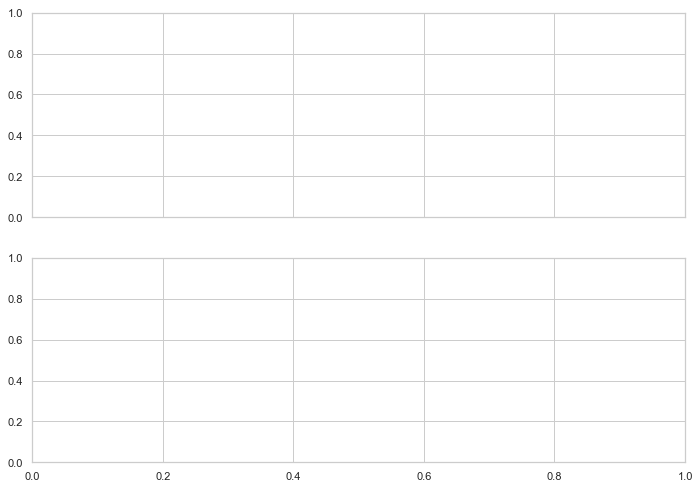

In [65]:
#PLOT BASE
import pandas as pd
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


#Variables

contable ="ConTPay"
cwd=os.getcwd()
database = 'TeacherSalary.db'
ss_db = os.path.join(cwd,database)
conn = sqlite3.connect(ss_db,isolation_level=None)
cur = conn.cursor()

#OCC_Code_Choice=()


#SQL
ContTPay_1st_sql = """SELECT STATE , year, A_MEAN FROM ConTPay WHERE ST in {} ;"""

def State5_inputs():
    print('\nWe will create a graph that compares Teacher Pay Trends Over the Last 20 Years.\n\nUse 2 character abbreviateions to choose 5 states to compare.\n')
    ST1 = input("State 1: ").upper()
    ST2 = input("State 2: ").upper()
    ST3 = input("State 3: ").upper()
    ST4 = input("State 4: ").upper()
    ST5 = input("State 5: ").upper()
    State5 = (ST1,ST2,ST3,ST4,ST5)
    print(State5)
    return State5 


def TeachGroup():
    print("Which Teacher Group to focus on?")
    TG = input("(E)lementary, (M)iddle, or (S)econdary school teachers?")
    # Finish later
    
# Load dataset
def SQL_to_DF(State5):
    with sqlite3.connect(ss_db) as conn:
        df={}
        df=pd.read_sql(ContTPay_1st_sql.format(State5), conn)
        #print(df)
        return df
        

#Run Statements
State5=State5_inputs()
df=SQL_to_DF(State5)
             

    
#PLOTS
#ax =sns.catplot(x='STATE', y='A_MEAN',hu e = 'year', kind="line", data=df)

#sns.set_context("poster", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(11.7,8.27), sharex=True)
ax1.sns.despine(left=False, bottom=False)
ax1.sns.cubehelix_palette(8, start=.5, rot=-.75)
ax1.sns.set_style("dark")

ax1sns.lineplot(x="year", y="A_MEAN",  hue = 'STATE', data=df) 
plt.show()

#if __name__== "__main__":  main()


In [29]:

#Check your package versions
import seaborn as sns
import numpy as np
import matplotlib as mpl
import scipy as sp

import pandas as pd


print("Seaborn", sns.__version__,"\nNumpy",np.__version__,"\nMatPlotLib",mpl.__version__,"\nScipy",sp.__version__,"\nPandas",pd.__version__ )

Seaborn 0.9.0 
Numpy 1.14.3 
MatPlotLib 2.2.2 
Scipy 1.1.0 
Pandas 0.23.0
